<a href="https://colab.research.google.com/github/mkbensalah/Prices_Prediction/blob/master/Prices_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# load libraries for data manipulation
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# load visualization libraries
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sb
sb.set()
# load modelling libraries
from sklearn.linear_model import Ridge,  Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import  cross_val_score
# warnings
import string
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load the train and test data sets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_len = len(train)
# combine train and test data sets
data_all = train.append(test, sort=False, ignore_index=True)
features = data_all.shape[1]
# check for duplicates
idUnique = len(set(data_all.Id))
idTotal = data_all.shape[0]
idDupli = idTotal - idUnique
print("There are " + str(idDupli) + " duplicate IDs for " + str(idTotal) + " total entries")
print("There are " + str(features) + " variables for " + str(idTotal) + " total entries")
# warnings
import string
import warnings
warnings.filterwarnings('ignore')

There are 0 duplicate IDs for 2919 total entries
There are 81 variables for 2919 total entries


In [ ]:
3# group variables in quantity(scale) and quality(categorical)
quantity = [f for f in data_all.columns if data_all.dtypes[f] != 'object']
quantity.remove('SalePrice')
quantity.remove('Id')
quality = [f for f in data_all.columns if data_all.dtypes[f] == 'object']

In [ ]:
print(quantity)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


There are 36 scale variables

In [ ]:
print(quality)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


There are 43 categorical variables

### 1.1 Scale Missing Values
Impute missing values for continous and count variables.

In [ ]:
missing_quant = (data_all[quantity].isnull().sum()/data_all[quantity].isnull().count()).sort_values(ascending=False)
missing_quant = missing_quant[missing_quant > 0] * 100
print("There are {} quantitative features with  missing values :".format(missing_quant.shape[0]))
missing_quant = pd.DataFrame({'Percent' :missing_quant})
missing_quant.head()

There are 11 quantitative features with  missing values :


,Percent
LotFrontage,16.649538
GarageYrBlt,5.447071
MasVnrArea,0.787941
BsmtHalfBath,0.068517
BsmtFullBath,0.068517


In [ ]:
np.where(pd.isnull(data_all.GarageArea))

(array([2576]),)

Index no. 2576 has no GarageArea and GarageCars and consequently no GarageYrBlt and hence GarageYrBlt will be filled with zero.

In [ ]:
# fill missing values
data_all['LotFrontage'] = data_all.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))
data_all.at[2576, 'GarageYrBlt'] = 0
data_all['GarageYrBlt'] = data_all.groupby(['Neighborhood'])['GarageYrBlt'].apply(lambda x: x.fillna(x.median()))
for col in ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars',
            'GarageArea']:
    data_all[col] = data_all[col].fillna(0)

### 1.2 Categorical Missing Values


In [ ]:
missing_qual = (data_all[quality].isnull().sum()/data_all[quality].isnull().count()).sort_values(ascending=False)
missing_qual = missing_qual[missing_qual > 0] * 100
print("There are {} qualitative features with  missing values :".format(missing_qual.shape[0]))
missing_qual = pd.DataFrame({'Percent' :missing_qual})
missing_qual.head(10)

There are 23 qualitative features with  missing values :


,Percent
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
GarageCond,5.447071
GarageQual,5.447071
GarageFinish,5.447071
GarageType,5.378554
BsmtCond,2.809181


There are features explicitly stated as NA on a property, those features will be filled with None, while other NA not explicitly assigned in the data description will be filled with the mode in the Neighborhood.

In [ ]:
# fill missing values
data_all['MSZoning'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['MSZoning'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['Utilities'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['Utilities'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['Exterior1st'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['Exterior1st'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['Exterior2nd'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['Exterior2nd'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['MasVnrType'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['MasVnrType'].apply(lambda x: x.fillna(x.value_counts().index[0]))
for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish',
           'GarageQual','GarageCond','Alley','Fence','PoolQC','MiscFeature']:
    data_all[col] = data_all[col].fillna('None')
data_all['Electrical'] = data_all.groupby(['Neighborhood','MSSubClass' ])['Electrical'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['KitchenQual'] = data_all.groupby(['Neighborhood','MSSubClass' ])['KitchenQual'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['Functional'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['Functional'].apply(lambda x: x.fillna(x.value_counts().index[0]))
data_all['SaleType'] = data_all.groupby(['Neighborhood', 'MSSubClass'])['SaleType'].apply(lambda x: x.fillna(x.value_counts().index[0]))

### 1.3 Outliers


In [ ]:
data_all.iloc[np.where(data_all.GrLivArea > 4000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260.0,Unf,0.0,878.0,3138.0,GasA,...,Y,SBrkr,3138,1538,0,4676,1.0,0.0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3.0,884.0,TA,TA,Y,208,406,0,0,0,0,None,None,None,0,10,2007,New,Partial,184750.0
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,989.0,2444.0,GasA,...,Y,SBrkr,2444,1872,0,4316,0.0,1.0,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3.0,832.0,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,1,2007,WD,Normal,755000.0
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,...,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000.0
1298,1299,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,...,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,None,None,0,1,2008,New,Partial,160000.0
2549,2550,20,RL,128.0,39290,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,...,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,None,None,None,17000,10,2007,New,Partial,NaN


3 of the houses are outliers, large houses prized relatively low, while the 2 on top in the scatter are very large houses with commensurate sales . The 2 outliers in the train set will be removed while the other outlier ID 2550 is in the test set .

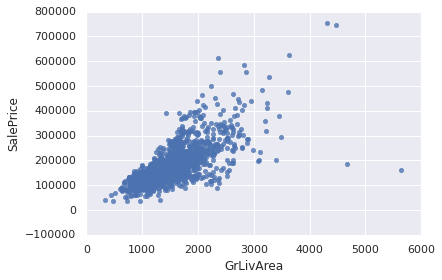

In [ ]:
scatter = sb.regplot(x='GrLivArea', y='SalePrice', fit_reg =False, data=data_all)

In [ ]:
# dropping the outliers in the train set
data_all = data_all.drop(data_all[data_all['Id'] == 524].index)
data_all = data_all.drop(data_all[data_all['Id'] == 1299].index)
# adjusting train len
train_len = train_len - 2
# fill the outlier in test set with the median
data_all.loc[2549,('GrLivArea')]  = data_all['GrLivArea'].median()
data_all.loc[2549,('LotArea')]  = data_all['LotArea'].median()

### 1.4 EDA
Test independent scale variables for linearity and normality 

 #### 1.4.1 Linearity Test

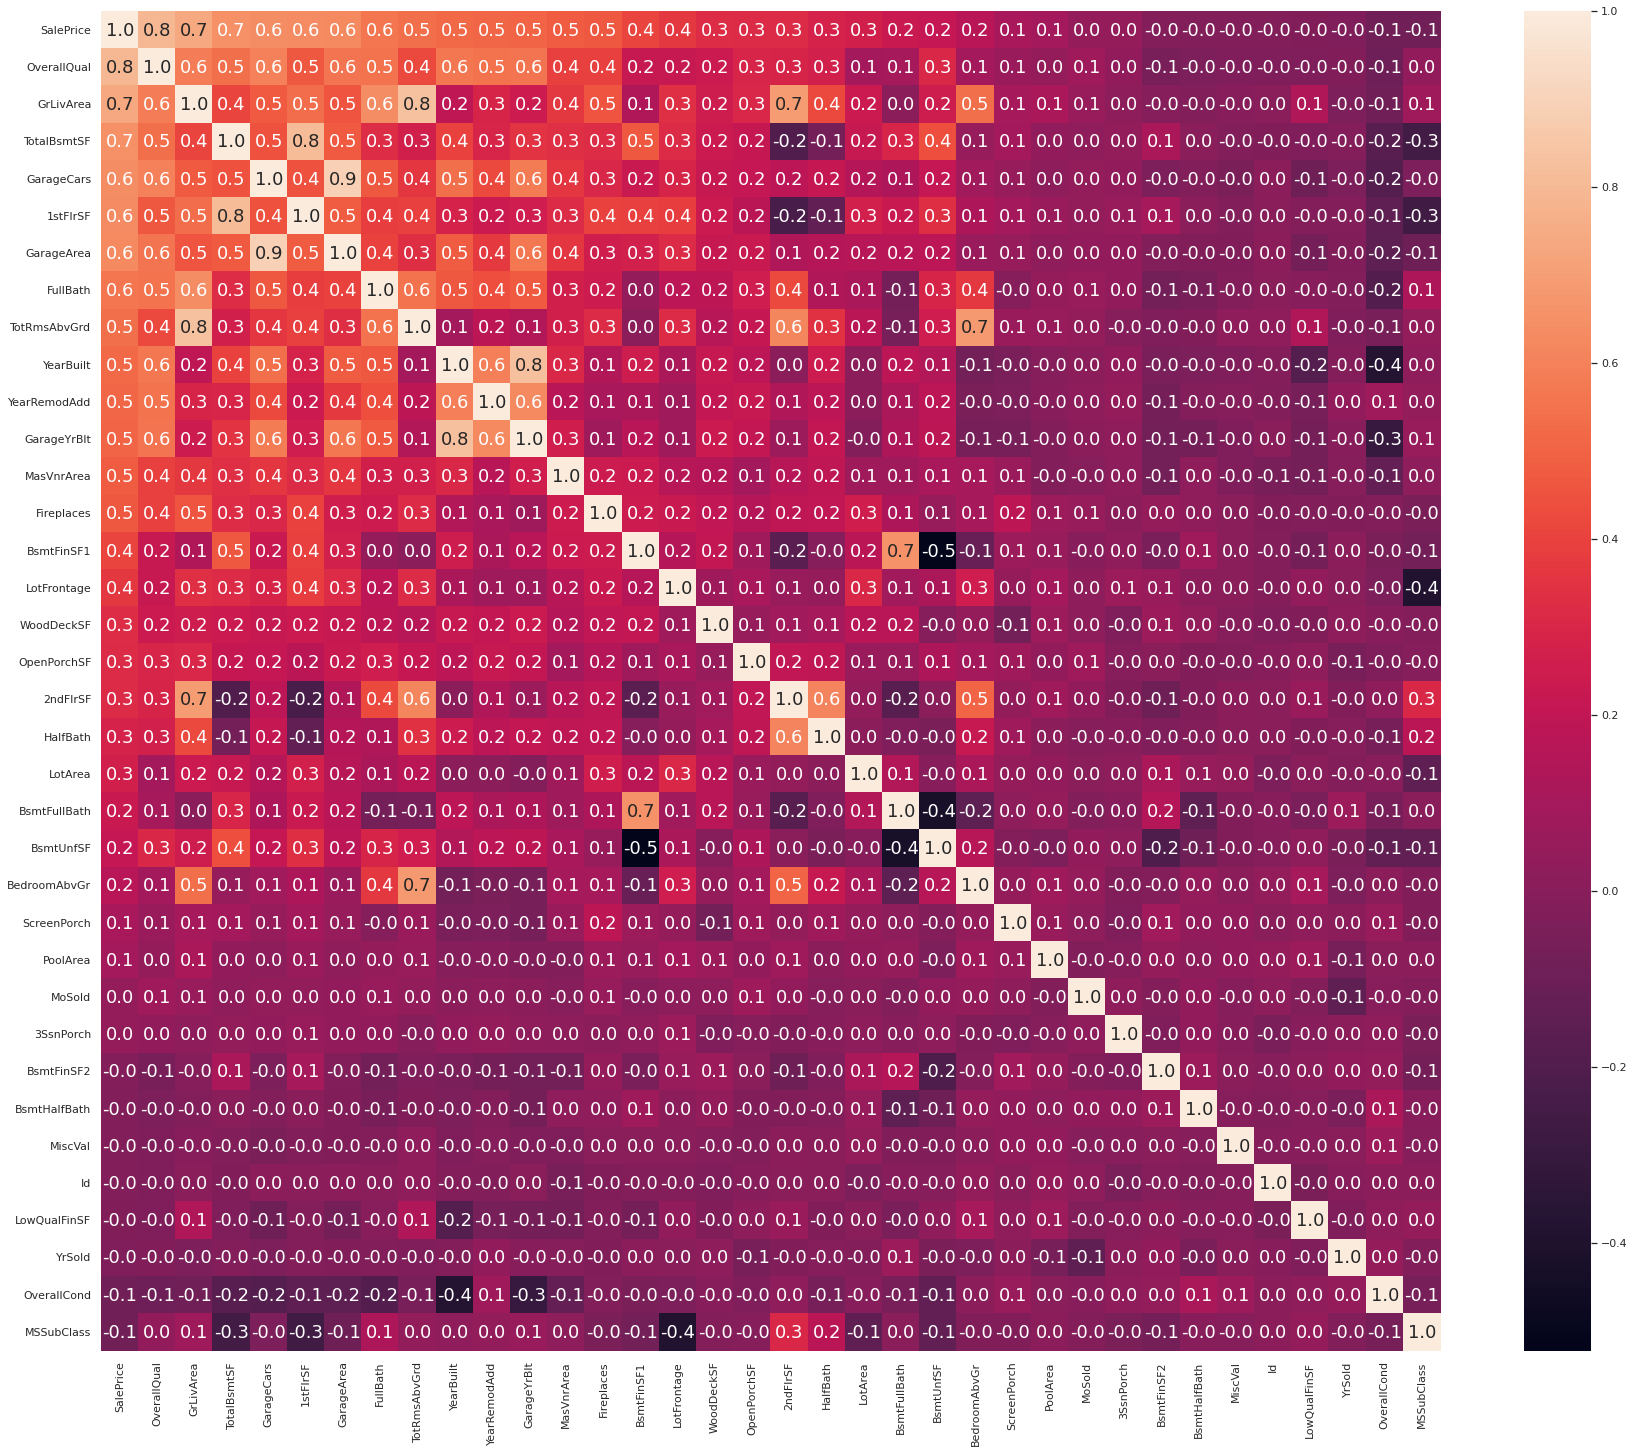

In [ ]:
#correlation matrix
corrmatrix = data_all[:train_len].corr()
f, ax = plt.subplots(figsize=(30, 24))
k = 36 
cols = corrmatrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_all[:train_len][cols].values.T)
sb.set(font_scale=1.0)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 18}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The heatmap shows some features have good correlation with the target and also high collinearity between GrLivArea/TotRmsAbvGrd, GarageCars/GarageArea, TotalBsmtSF/1stFlrSF and YearBuilt/GarageYrBlt. However there are features with low correaltion with the target (i.e. absolute correlation between 0.0 and 3.0)

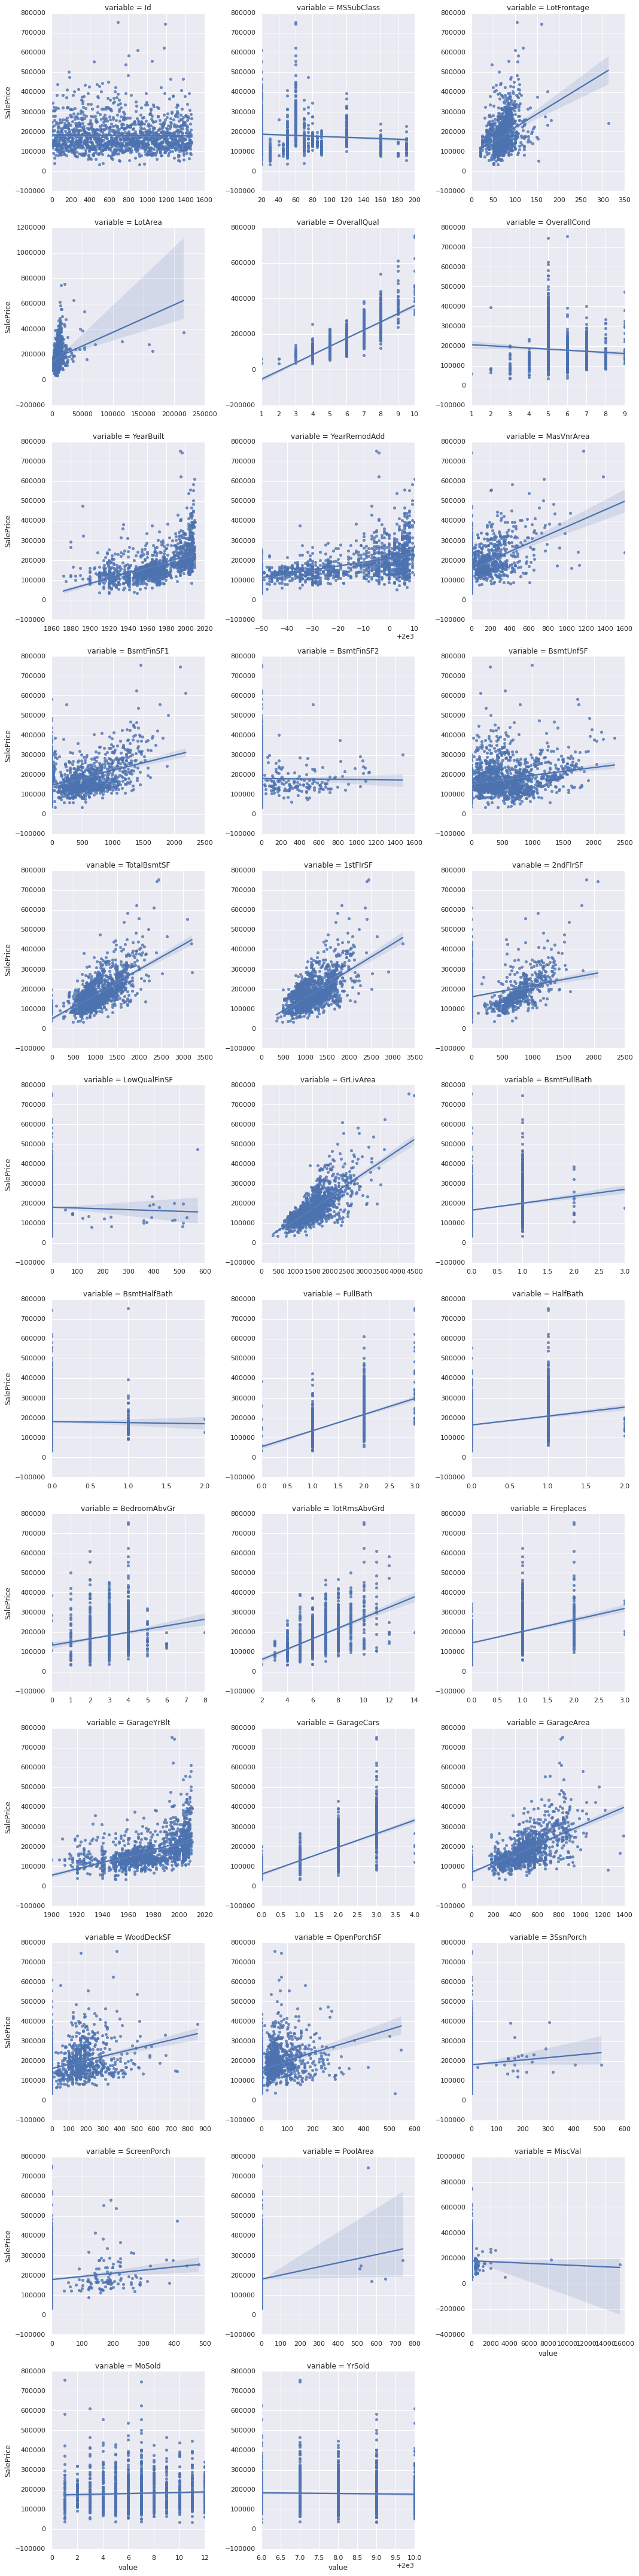

In [ ]:
# scatterplot of dependent vs independent variables
quantitative = [f for f in data_all.columns if f in cols]
quantitative.remove('SalePrice')
varx = pd.melt(data_all, id_vars=['SalePrice'], value_vars=quantitative)
gx = sb.FacetGrid(varx, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5)
gx = gx.map(sb.regplot, "value", "SalePrice")

The independent variables show weak, moderate and high lineaity with the target, some with increasing linearity with the target and some with decreasing linearity with the target. The following features show decreasing lineraity - OverallCond, BsmtFinSF2, LowQualFinSF, BsmtHalfBath, MiscVal and YrSold.

#### 1.4.2 Normality Test

In [ ]:
# distribution plot of dependent and independent variables
#quantitative = [f for f in data_all.columns if f in cols]
#varx = pd.melt(data_all, value_vars=quantitative)
#gx = sb.FacetGrid(varx, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5)
#gx = gx.map(sb.distplot, ("value"), fit=norm)

No distribution is normally distributed, skewness and kurtosis enable us to assess deviation from normality. The variables with moderate to high skew will need a transformation to make them approximately normally distributed.

## 2. 0 Data Manipulations

Create new variables, and transform features for modeling


### 2.1 Feature Extraction
Create new features from existing features. There are 2 types of categorical variables, nominal and ordinal. The ordinal variables show some rank and will be encoded with numeric values.

In [ ]:
# impute ordinal data with numeric values
data_all['KitchenQual'].replace(['Ex','Gd','TA','Fa'],[4,3,2,1],inplace=True)
data_all['FireplaceQu'].replace(['Ex','Gd','TA','Fa','Po', 'None'],[6,5,4,3,2,1],inplace=True)
data_all['GarageQual'].replace(['Ex','Gd','TA','Fa','Po','None'],[6,5,4,3,2,1],inplace=True)
data_all['GarageCond'].replace(['Ex','Gd','TA','Fa','Po','None'],[6,5,4,3,2,1],inplace=True)
data_all['PoolQC'].replace(['Ex','Gd','TA','Fa','None'],[5,4,3,2,1],inplace=True)
data_all['ExterQual'].replace(['Ex','Gd','TA','Fa'],[4,3,2,1],inplace=True)
data_all['ExterCond'].replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
data_all['BsmtQual'].replace(['Ex','Gd','TA','Fa','Po','None'],[6,5,4,3,2,1],inplace=True)
data_all['BsmtCond'].replace(['Ex','Gd','TA','Fa','Po','None'],[6,5,4,3,2,1],inplace=True)
data_all['BsmtExposure'].replace(['Gd','Av','Mn','No','None'],[5,4,3,2,1],inplace=True)
data_all['HeatingQC'].replace(['Ex','Gd','TA','Fa','Po'],[5,4,3,2,1],inplace=True)
# transform discrete features to  categorical feature
data_all['MSSubClass'] = data_all['MSSubClass'].astype(str)
data_all['YrSold'] =    data_all['YrSold'].astype(str)   
data_all['MoSold'] =    data_all['MoSold'].astype(str)  

Combime some old features to form new ones.

In [ ]:
# combinations of old features
data_all['GarageScale'] = data_all['GarageCars'] * data_all['GarageArea']
data_all['GarageOrdinal'] = data_all['GarageQual'] + data_all['GarageCond']
data_all['AllPorch'] = data_all['OpenPorchSF'] + data_all['EnclosedPorch'] + data_all['3SsnPorch'] + data_all['ScreenPorch']
data_all['ExterOrdinal'] = data_all['ExterQual'] + data_all['ExterCond']
data_all['KitchenCombined'] = data_all['KitchenQual'] * data_all['KitchenAbvGr']
data_all['FireplaceCombined'] = data_all['FireplaceQu'] * data_all['Fireplaces']
data_all['BsmtOrdinal'] = data_all['BsmtQual'] + data_all['BsmtCond']
data_all['BsmtFinishedAll'] = data_all['BsmtFinSF1'] + data_all['BsmtFinSF2']
data_all['AllFlrSF'] = data_all['1stFlrSF'] + data_all['2ndFlrSF']
data_all['OverallCombined'] = data_all['OverallQual'] + data_all['OverallCond']
data_all['TotalFullBath'] = data_all['BsmtFullBath'] +  + data_all["FullBath"] 
data_all['TotalHalfBath'] = data_all["HalfBath"] + data_all['BsmtHalfBath']
data_all['TotalSF'] = data_all['AllFlrSF'] + data_all['TotalBsmtSF']
data_all['YrBltAndRemod'] = data_all["YearRemodAdd"] + data_all['YearBuilt']

### 2.2 Categorical Encoding
Encode categoricals with one hot encoding

In [ ]:
cat_features = [f for f in data_all.columns if data_all.dtypes[f] == 'object']
categorical = []
for i in data_all.columns:
    if i in cat_features:
        categorical.append(i)
data_cat = data_all[categorical]
data_cat = pd.get_dummies(data_cat)

Features with zero values that can be described as almost 100% can cause overfitting and will be dropped. 

In [ ]:
# Drop features with zeros > 99.95
overfit = []
for i in data_cat.columns:
    counts = data_cat[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(data_cat) * 100 > 99.95:
        overfit.append(i)
data_cat = data_cat.drop(overfit, axis=1)
print("There are {} qualitative features with zeros > 99.95 :".format(len(overfit)))

There are 13 qualitative features with zeros > 99.95 :


### 2.3 Numeric Feature Optimization
Select features with minimal linearity and reduce skews to symetrical normal distribution

#### 2.3.1 Linearity with Target


In [ ]:
numeric = [f for f in data_all.columns if data_all.dtypes[f] != 'object']
numeric.remove('Id')
#calculate spearman corr. coef.
features = numeric
spr = pd.DataFrame()
spr['feature'] = features
spr['spearman'] = [data_all[f].corr(data_all['SalePrice'], 'spearman') for f in features]
spr = spr.sort_values('spearman')
numeric_cols = spr['feature'].tail(47)# select features with corr. approximately => 0.2
#plot spearman corr. coef.
plt.figure(figsize=(6, 0.25*len(features)))
bar = sb.barplot(data=spr, y='feature', x='spearman', orient='h')

NameError: ignored

#### 2.3.2 Normality and Homogeneity of Variance
Homogeneity of variance is simply having equal spreads between the predictor variable and the target variable. It ensures the error is same across all values of the predictor variable. This is acheived by reducing a skewed distribution to an approximately symmetrical normal distribution and can impact on linear model performance.

Log transformation of the target variable will reduce deviation from a normal distribution and reduce errors in predicting expensive and cheap houses.

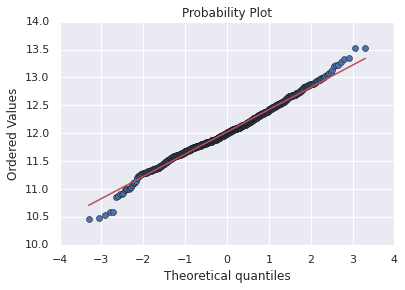

In [ ]:
# Log transform the target
data_all[:train_len].loc[:,('SalePrice')] = np.log1p(data_all[:train_len]['SalePrice'])
# test SalePrice for normality
fig = plt.figure()
res = stats.probplot(data_all[:train_len]['SalePrice'], plot=plt)

Probability plot indicates SalePrice deviation from a normal distribution is not significant.

In [ ]:
# gather numerical features
numerical = numeric_cols.values.tolist()
numerical.remove('SalePrice')
data_num = data_all[numerical].astype(float)
# calculate skewness 
skewness = data_num.apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[abs(skewness) > 0.5]
print("There are {} numerical features with absolute Skew > 0.5 :".format(skewness.shape[0]))
skewness = pd.DataFrame({'Skew' :skewness})
skewness.head(10)

There are 35 numerical features with absolute Skew > 0.5 :


,Skew
LotArea,13.190015
MasVnrArea,2.621719
OpenPorchSF,2.529358
AllPorch,2.244500
WoodDeckSF,1.844792
GarageScale,1.418689
1stFlrSF,1.257286
BsmtExposure,1.119066
LotFrontage,1.102764
AllFlrSF,1.046056


Use Box-Cox transformation to reduce skewed features to an approximately normal distribution.

In [ ]:
# Box-Cox transformation
for i in skewness.index.tolist():
    data_num[i] = boxcox1p(data_num[i], boxcox_normmax(data_num[i] + 1))

 Manual skew reduction will be attempted for moderate and high skewed features. Features that cannot be reduced to < 1.0 will be dropped 

In [ ]:
# calculate skewness 
skewness = data_num.apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[abs(skewness) > 0.5]
# transforming negative skewed features
neg_skew = skewness[skewness < 0]
data_num.loc[:,('GarageOrdinal')] = data_num['GarageOrdinal']**1.1
data_num.loc[:,('GarageQual')] = data_num['GarageQual']**1.2
data_num.loc[:,('GarageCond')] = data_num['GarageCond']**1.3
data_num.loc[:,('HeatingQC')] = data_num['HeatingQC']**1.6
# transforming positive skewed features
pos_skew = skewness[skewness > 0]
pos_skew1 = ['Fireplaces','BsmtFullBath','OpenPorchSF','FireplaceCombined','TotalHalfBath',
             'WoodDeckSF','2ndFlrSF']
data_num.loc[:,pos_skew1] = np.sqrt(data_num[pos_skew1])
data_num.loc[:,('HalfBath')] = np.cbrt(data_num['HalfBath'])
data_num.loc[:,('MasVnrArea')] = np.log2(data_num['MasVnrArea']+1)
# check high skewed features
skewness = data_num.apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[abs(skewness) > 1.0]
# Drop highly skewed features
data_num = data_num.drop(skewness.index.tolist(), axis=1)
print("There are {} numerical features with absolute Skew > 1.0 :".format(skewness.shape[0]))

There are 0 numerical features with absolute Skew > 1.0 :


Graph of GrLivArea and SalePrice showing equal levels of SalePrice dispersion among the values of GrLivArea after both variable satisfaction of an approximately symmetrical normal distribution.

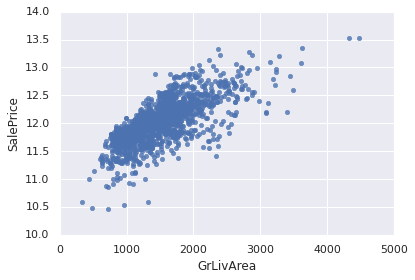

In [ ]:
scatter = sb.regplot(x='GrLivArea', y='SalePrice', fit_reg =False, data=data_all)

Separate train and test sets for modeling

In [ ]:
# convert numerical features to standard score
data_num = (data_num - data_num.mean())/data_num.std()
# separate train and test sets
df_all = pd.concat([data_num, data_cat], axis = 1)
features = (data_cat.columns).append(data_num.columns)
df_train = df_all[:1458]
df_test = df_all[1458:]
target = 'SalePrice'
X = df_train[features]
y = data_all[:1458][target]
X_test = df_test[features]

## 3. Modeling
Cross validation and model evaluation

In [ ]:
# Defining RMSE
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

#### 3.1.1 Linear Regressors

In [ ]:
# Ridge CV and model fitting
ridge = Ridge(alpha = 14)
cv_ridge = rmse_cv(ridge)
ridge.fit(X , y)
print('Ridge CV score min: ' + str(cv_ridge.min()) + ' mean: ' + str(cv_ridge.mean()) 
      + ' max: ' + str(cv_ridge.max()) )

Ridge CV score min: 0.1036581043660658 mean: 0.11239165764570817 max: 0.12146935798605127


In [ ]:
# Ridge features
coefs = pd.Series(ridge.coef_, index = X.columns)

print("Ridge selected " + str(sum(coefs != 0)) + " features and discarded " +  str(sum(coefs == 0)) + " features")

Ridge selected 276 features and discarded 0 features


In [ ]:
# Lasso CV and model fitting
lasso = Lasso(alpha = .00066)
cv_lasso = rmse_cv(lasso)
lasso.fit(X, y)
print('Lasso CV score min: ' + str(cv_lasso.min()) + ' mean: ' + str(cv_lasso.mean()) 
      + ' max: ' + str(cv_lasso.max()) )

Lasso CV score min: 0.10170054606403704 mean: 0.10990737060384785 max: 0.11933392607137153


Lasso selected 93 features and discarded 183 features


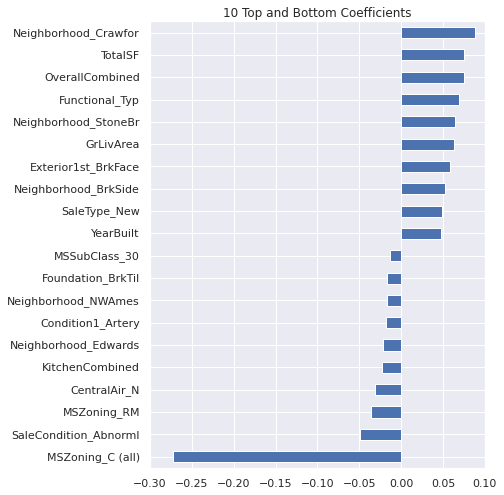

In [ ]:
# Plot lasso important coefficients
coefs = pd.Series(lasso.coef_, index = X.columns)
print("Lasso selected " + str(sum(coefs != 0)) + " features and discarded " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
plt.figure(figsize=(6, 8))
imp_coefs.plot(kind = "barh")
plt.title("10 Top and Bottom Coefficients")
plt.show()

In [ ]:
# ElasticNet CV and model fitting
elasticnet = ElasticNet(alpha = .00066, l1_ratio=1.0)
cv_elasticnet = rmse_cv(elasticnet)
elasticnet.fit(X , y)
print('ElasticNet CV score min: ' + str(cv_elasticnet.min()) + ' mean: ' + str(cv_elasticnet.mean()) 
      + ' max: ' + str(cv_elasticnet.max()) )

ElasticNet CV score min: 0.10170054606403704 mean: 0.10990737060384785 max: 0.11933392607137153


In [ ]:
# ElasticNet features
coefs = pd.Series(elasticnet.coef_, index = X.columns)
print("ElasticNet selected " + str(sum(coefs != 0)) + " features and discarded " +  str(sum(coefs == 0)) + " features")

ElasticNet selected 93 features and discarded 183 features


#### 3.1.2 Gradient Boosting Regressor

In [ ]:
# GradientBoostng CV and model fitting
gbrt = GradientBoostingRegressor(n_estimators=1000, learning_rate=.03, max_depth=3, max_features=.04, min_samples_split=4,
                                 min_samples_leaf=3, loss='huber', subsample=1.0, random_state=0)
cv_gbrt = rmse_cv(gbrt)
gbrt.fit(X, y)
print('GradientBoosting CV score min: ' + str(cv_gbrt.min()) + ' mean: ' + str(cv_gbrt.mean()) 
      + ' max: ' + str(cv_gbrt.max()) )

GradientBoosting CV score min: 0.10044871363416703 mean: 0.1102525916547175 max: 0.11748804085079831


### 3.2 Model Evaluation

In [ ]:
from datetime import datetime
# model blending 
def blend_models(X):
    return ((ridge.predict(X)) + (gbrt.predict(X)))/2

ridge_preds =  np.expm1(ridge.predict(X_test))
gbrt_preds = np.expm1(gbrt.predict(X_test))

ridge_gbrt_preds = np.expm1(blend_models(X_test))
hp_ridge_gbrt = pd.DataFrame({'Id':test.Id, 'SalePrice':ridge_gbrt_preds})
hp_ridge_gbrt.to_csv('solution.csv', index = False)
print('Version 7 submitted on', datetime.now())

Version 7 submitted on 2020-07-28 21:52:51.043183


Plotting relationship between ridge and gbrt predictions

Text(0, 0.5, 'ridge')

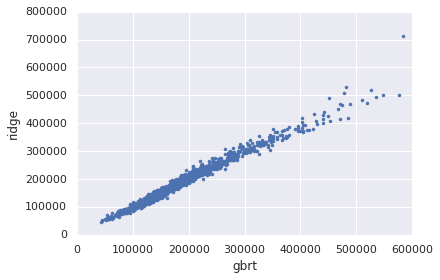

In [ ]:
fig = plt.figure(figsize=(6, 4))
axes = fig.add_subplot(1,1,1)
predictions = pd.DataFrame({"ridge":ridge_preds, "gbrt":gbrt_preds})
plt.plot(gbrt_preds, ridge_preds, '.')
axes.set_xlabel('gbrt')
axes.set_ylabel('ridge')

#### Conclusion

If you have gone this far, thanks for taking your time to go through my kernel. Beyond feature engineering, hyper parameter tuning coupled with hybrid regression gave a <b>LB score of 0.11904 top 5%</b> at the time of submission.